연습문제 2. Image Classifier를 위한 SHAP 구현하기
==============================

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 29.8 MB/s 


In [ ]:
|import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
batch_size = 100
learning_rate = 0.001
num_epochs = 20

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to FashionMNIST/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to FashionMNIST/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to FashionMNIST/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to FashionMNIST/FashionMNIST/raw



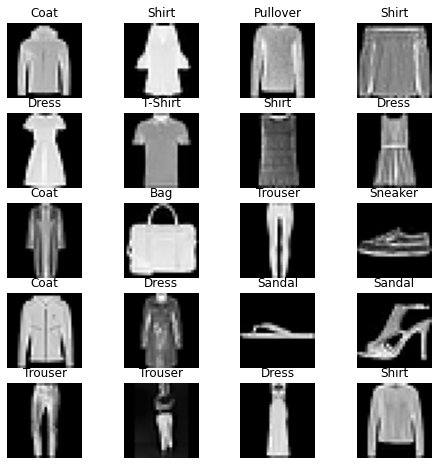

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])


# 데이터셋 내려받기(fashion_mnist)
train_dataset  = torchvision.datasets.FashionMNIST("FashionMNIST/", download = True, train = True, transform = transform)
test_dataset  = torchvision.datasets.FashionMNIST("FashionMNIST/", download = True, train = False, transform = transform)

#fashion_mnist 데이터 데이터로더에 전달
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size)

#분류에 사용될 클래스 정의
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'}

fig = plt.figure(figsize=(8,8));
columns = 4;
rows = 5;
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_dataset));
    img = train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

In [ ]:
#심층신경망 모델 생성
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return x

In [ ]:
criterion = nn.CrossEntropyLoss();

model = FashionCNN();
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);

In [ ]:
#모델 학습
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not (count % 50):    
            total = 0
            correct = 0        
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)        
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

Iteration: 500, Loss: 1.7950549125671387, Accuracy: 66.58999633789062%
Iteration: 1000, Loss: 1.7263232469558716, Accuracy: 69.05999755859375%
Iteration: 1500, Loss: 1.7400277853012085, Accuracy: 70.90999603271484%
Iteration: 2000, Loss: 1.7850217819213867, Accuracy: 72.22000122070312%
Iteration: 2500, Loss: 1.7846274375915527, Accuracy: 72.83999633789062%
Iteration: 3000, Loss: 1.7528038024902344, Accuracy: 72.47999572753906%
Iteration: 3500, Loss: 1.7199978828430176, Accuracy: 74.47000122070312%
Iteration: 4000, Loss: 1.6400771141052246, Accuracy: 77.47000122070312%
Iteration: 4500, Loss: 1.659427523612976, Accuracy: 78.33000183105469%
Iteration: 5000, Loss: 1.700129747390747, Accuracy: 79.68000030517578%
Iteration: 5500, Loss: 1.6496531963348389, Accuracy: 80.29000091552734%
Iteration: 6000, Loss: 1.6324254274368286, Accuracy: 80.81999969482422%
Iteration: 6500, Loss: 1.6283917427062988, Accuracy: 81.40999603271484%
Iteration: 7000, Loss: 1.634553074836731, Accuracy: 81.180000305175

In [ ]:
torch.save(model,'./model.pth')

GroundTruth :  Ankle Boot
Prediction :  Ankle Boot


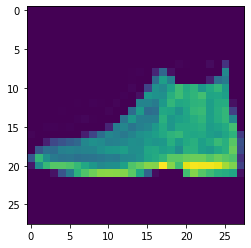

In [ ]:
x, y = next(iter(test_loader))
data_num = 0
img = x[data_num]
plt.imshow(img.view(28,28))
img = img.to(device)
groundtruth = labels_map[y[data_num].item()]
print('GroundTruth : ', groundtruth)
outputs = model(img.unsqueeze(0))            
predictions = torch.max(outputs, 1)[1].to(device)
predict = labels_map[predictions.item()]
print('Prediction : ',predict)

In [ ]:
import shap
x = x.to(device)
test_images = x[:3]
background = x[3:]
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [ ]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.detach().cpu().numpy(), 1, -1), 1, 2)

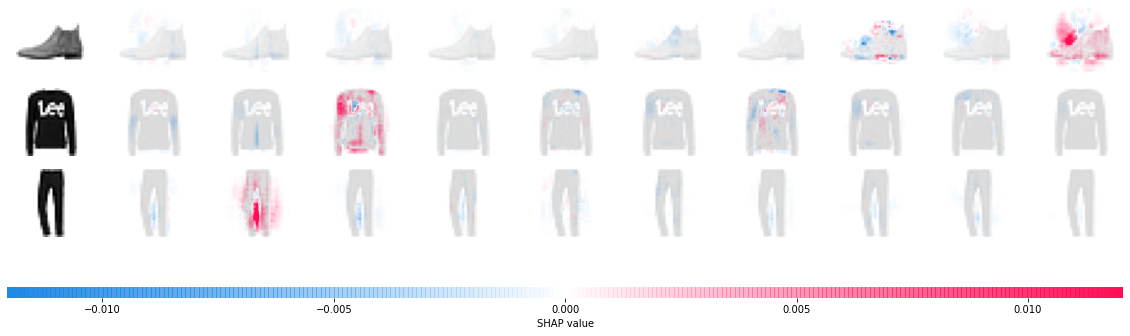

In [ ]:
# plot the feature attributions
shap.image_plot(shap_numpy, -test_numpy)